# Active Transport and Air Quality Impact

**Authored by**:  Ngoc Bao Son Nguyen

**Duration**: 90 mins

**Level**: Intermediate

**Pre-requisite Skills**: Python, Pandas, Matplotlib, Seaborn


### Scenario

As a policy adviser for sustainable urban development, I want to uncover clear trends showing how increased walking and cycling activity align with lower air pollutant levels (e.g., PM2.5, PM10). The aim's to back data-driven decisions for expanding active transport infrastructure.

As a policy adviser working on clean air initiatives, I want to compare annual and seasonal variations in active transport use with changes in air quality, so I can evaluate the environmental impact of transport policies and propose further emission-reduction strategies.

As a policy adviser guiding city planning teams, I want to visualise and communicate the positive correlation between active mobility and improved air quality, so that I can influence future transport and health policy frameworks that promote walking and cycling in Melbourne.

### What this use case will teach you

At the end of this use case, you will demonstrate:

- Collected, converted datasets from different formats, and merged multiple open datasets (e.g., pedestrian counts, bike usage, and air quality).

- Preprocessed and transformed raw data to ensure robust, reliable time-series analysis.

- Conducted visual and statistical exploratory data analysis (EDA) to investigate correlations and seasonal trends between active transport and pollutant levels.

- Applied advanced machine learning and statistical methods to predict the impact of the increasing walking and cycling activity on air quality.

### Background and Introduction

With concerns about climate change, urban pollution, and sustainable development growing, cities around the world are turning to active transport-cycling and walking-as a core way to cut emissions and boost public health. In Melbourne, efforts to broaden cycling networks and create more pedestrian-friendly zones fit with the city's broader goals: cleaner air and a shift toward low-carbon living.

Meanwhile, easy access to timely, location-specific data lets us measure how these active-transport efforts relate to environmental outcomes. Understanding whether more people on bikes and on foot actually improves air quality can help inform evidence-based policymaking, smarter infrastructure investments, and more engaged communities.

This use case looks at how active transport activity and air-pollution trends in Melbourne relate, using a series of interactive data visualisations and statistical analyses. By pairing datasets on pedestrian and bicycle counts with air-quality indicators from 2019 to 2024, the analysis serves two main user groups:

- Urban planners and environmental policy advisers can assess whether promoting active transport correlates with reductions in particulate pollution and use these insights to shape future investments and public-health strategies.
- Researchers and sustainability advocates can explore seasonal and longitudinal trends in active mobility and pollution, identifying key periods or interventions that may have produced measurable impacts.

By integrating active-transport and air-quality datasets, this tool offers a holistic view of how changes in urban mobility behavior might influence environmental health, supporting smarter, greener city development across Melbourne.

### Datasets used
- [Bicycle volume](https://opendata.transport.vic.gov.au/dataset/bicycle-volume-and-speed/resource/cca05f99-edf9-4226-8fb2-f2bde639c40f?inner_span=True) <br>
This dataset tracks hourly counts and speeds of bicycles detected at counting stations across Victoria-including the City of Melbourne. It sheds light on cycling activity patterns over time and across locations.

- [Air Quality](https://discover.data.vic.gov.au/dataset/epa-air-watch-all-sites-air-quality-hourly-averages-yearly/historical)<br>
This dataset provides hourly averages of key air pollutants-PM10, BPM2.5, SBPM25, and more-collected from monitoring stations across Victoria. It lets you track air quality over time and across different sites.

- [Pedestrian Count](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/?sort=sensing_date) <br>
This dataset tracks hourly pedestrian activity from sensor locations across the City of Melbourne. It offers detailed counts by time, date, and location, so you can spot walking patterns and foot traffic trends.

### Importing Packages

This section imports essential libraries to be used for analyse the use case

In [45]:
import requests
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import io
import os
import shutil
import gc
import statsmodels.api as sm

### Importing Datasets

This section loads all external datasets used in the analysis, including pedestrian counts, bicycle volumes, air quality measurements, and network infrastructure data. It also handles importing data via APIs, converting zip files and xlsx files to dataframe where applicable, ensuring each dataset is structured and ready for cleaning, merging, and further exploration.

In [4]:
def process_one_zip(zip_name, zip_dir, extract_dir='/content/unzipped_temp'):
    outer_zip_path = os.path.join(zip_dir, zip_name)

    if os.path.exists(extract_dir):
        shutil.rmtree(extract_dir)
    os.makedirs(extract_dir, exist_ok=True)

    try:
        with zipfile.ZipFile(outer_zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f" Extracted outer ZIP: {zip_name}")
    except zipfile.BadZipFile:
        print(f" Bad ZIP file: {zip_name}")
        return None

    for root, dirs, files in os.walk(extract_dir):
        for file in files:
            if file.lower().endswith(".zip"):
                inner_zip_path = os.path.join(root, file)
                inner_extract_path = os.path.join(root, os.path.splitext(file)[0])
                os.makedirs(inner_extract_path, exist_ok=True)
                try:
                    with zipfile.ZipFile(inner_zip_path, 'r') as zip_ref:
                        zip_ref.extractall(inner_extract_path)
                except zipfile.BadZipFile:
                    print(f" Skipping corrupted ZIP: {inner_zip_path}")

    zip_df_list = []
    for root, dirs, files in os.walk(extract_dir):
        for file in files:
            if file.lower().endswith(".csv"):
                csv_path = os.path.join(root, file)
                try:
                    df = pd.read_csv(csv_path)
                    df['source_file'] = file
                    zip_df_list.append(df)
                except Exception as e:
                    print(f" Failed to read {csv_path}: {e}")

    if zip_df_list:
        combined_df = pd.concat(zip_df_list, ignore_index=True)
        print(f" Combined CSVs from {zip_name} — shape: {combined_df.shape}")
        return combined_df
    else:
        print(f" No CSV files found in {zip_name}")
        return None

In [5]:
bicycle_count_2019 = process_one_zip('bicycle_volume_speed_2019.zip', zip_dir='.')
bicycle_count_2019.head()

 Extracted outer ZIP: bicycle_volume_speed_2019.zip
 Combined CSVs from bicycle_volume_speed_2019.zip — shape: (12592805, 18)


,DATA_TYPE,TIS_DATA_REQUEST,SITE_XN_ROUTE,LOC_LEG,DATE,TIME,CLASS,LANE,SPEED,WHEELBASE,HEADWAY,GAP,AXLE,AXLE_GROUPING,RHO,VEHICLE,DIRECTION,source_file
0,IND,208,32612,61171,01/12/2018,11:03:44,15,0,13.8,1.0,0.0,0.0,2,1,1.0,CYCLE,N,IND_D208_X32612.csv
1,IND,208,32612,61172,01/12/2018,11:05:58,15,1,23.7,1.0,134.5,134.6,2,1,1.0,CYCLE,S,IND_D208_X32612.csv
2,IND,208,32612,61171,01/12/2018,11:08:47,15,0,12.5,1.0,303.3,303.0,2,1,1.0,CYCLE,N,IND_D208_X32612.csv
3,IND,208,32612,61172,01/12/2018,11:09:41,15,1,27.5,1.1,222.3,222.2,2,1,1.0,CYCLE,S,IND_D208_X32612.csv
4,IND,208,32612,61172,01/12/2018,11:12:08,15,1,19.8,1.0,147.4,147.3,2,1,1.0,CYCLE,S,IND_D208_X32612.csv


In [6]:
bicycle_count_2023 = process_one_zip('bicycle_volume_speed_2023.zip', zip_dir='.')
bicycle_count_2023.head()

 Extracted outer ZIP: bicycle_volume_speed_2023.zip


C:\Users\PCs\AppData\Local\Temp\ipykernel_20808\4246809728.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(zip_df_list, ignore_index=True)


 Combined CSVs from bicycle_volume_speed_2023.zip — shape: (10467615, 18)


,DATA_TYPE,TIS_DATA_REQUEST,SITE_XN_ROUTE,LOC_LEG,DATE,TIME,CLASS,LANE,SPEED,WHEELBASE,HEADWAY,GAP,AXLE,AXLE_GROUPING,RHO,VEHICLE,DIRECTION,source_file
0,IND,208,10223,59443,26/12/2022,04:58:18,15,0,17.3,1.1,44.7,44.7,2,1,1.0,CYCLE,N,IND_D208_X10223_NS0_20230102.csv
1,IND,208,10223,59443,26/12/2022,05:42:26,15,0,26.9,1.0,2648.2,2648.0,2,1,1.0,CYCLE,N,IND_D208_X10223_NS0_20230102.csv
2,IND,208,10223,59444,26/12/2022,05:45:13,15,1,19.3,1.0,2860.2,2860.3,2,1,1.0,CYCLE,S,IND_D208_X10223_NS0_20230102.csv
3,IND,208,10223,59443,26/12/2022,05:49:07,15,0,25.9,1.1,157.9,157.7,2,1,1.0,CYCLE,N,IND_D208_X10223_NS0_20230102.csv
4,IND,208,10223,59443,26/12/2022,05:52:19,15,0,21.7,1.1,192.2,192.1,2,1,1.0,CYCLE,N,IND_D208_X10223_NS0_20230102.csv


In [7]:
bicycle_count_2024 = process_one_zip('bicycle_volume_speed_2024.zip', zip_dir='.')
bicycle_count_2024.head()

 Extracted outer ZIP: bicycle_volume_speed_2024.zip


C:\Users\PCs\AppData\Local\Temp\ipykernel_20808\4246809728.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(zip_df_list, ignore_index=True)


 Combined CSVs from bicycle_volume_speed_2024.zip — shape: (5549004, 18)


,DATA_TYPE,TIS_DATA_REQUEST,SITE_XN_ROUTE,LOC_LEG,DATE,TIME,CLASS,LANE,SPEED,WHEELBASE,HEADWAY,GAP,AXLE,AXLE_GROUPING,RHO,VEHICLE,DIRECTION,source_file
0,IND,208,10223,59443,25/12/2023,05:21:45,15,0,25.3,1.1,967.7,967.7,2,1,1.0,CYCLE,N,IND_D208_X10223_NS0_20240101.csv
1,IND,208,10223,59444,25/12/2023,05:41:27,15,1,11.8,1.1,2150.6,2150.7,2,1,1.0,CYCLE,S,IND_D208_X10223_NS0_20240101.csv
2,IND,208,10223,59443,25/12/2023,05:56:58,15,0,24.1,1.1,2113.8,2113.6,2,1,1.0,CYCLE,N,IND_D208_X10223_NS0_20240101.csv
3,IND,208,10223,59444,25/12/2023,06:12:05,15,1,13.7,1.1,1837.9,1837.5,2,1,1.0,CYCLE,S,IND_D208_X10223_NS0_20240101.csv
4,IND,208,10223,59443,25/12/2023,06:37:31,15,0,25.5,1.1,1285.7,1285.7,2,1,1.0,CYCLE,N,IND_D208_X10223_NS0_20240101.csv


In [8]:
air_quality_2019 = pd.read_excel("2019_air_quality.xlsx")
air_quality_2019.head()

,sample_point_id,sp_name,latitude,longitude,sample_datetime,time_basis_id,param_id,param_name,value,param_std_unit_of_measure,param_short_name
0,10001,Alphington,-37.778408,145.030594,2019-01-01 00:00:00,1HR_AV,BPM2.5,BAM Particles < 2.5 micron,9.6,ug/m3,PM2.5
1,10001,Alphington,-37.778408,145.030594,2019-01-01 00:00:00,1HR_AV,PM10,TEOM Particles <10micron,15.5,ug/m3,PM10
2,10001,Alphington,-37.778408,145.030594,2019-01-01 01:00:00,1HR_AV,BPM2.5,BAM Particles < 2.5 micron,4.7,ug/m3,PM2.5
3,10001,Alphington,-37.778408,145.030594,2019-01-01 01:00:00,1HR_AV,PM10,TEOM Particles <10micron,11.7,ug/m3,PM10
4,10001,Alphington,-37.778408,145.030594,2019-01-01 02:00:00,1HR_AV,BPM2.5,BAM Particles < 2.5 micron,1.8,ug/m3,PM2.5


In [9]:
air_quality_2023 = pd.read_excel("2023_air_quality.xlsx")
air_quality_2023.head()

,datetime_AEST,datetime_local,location_id,location_name,latitude,longitude,value,validation_flag,parameter_name,parameter_method_name
0,2022-12-31 23:00:00,2023-01-01 00:00:00,10136,Mooroolbark,-37.774967,145.328500,10.000,Y,PM10,PM10
1,2022-12-31 23:00:00,2023-01-01 00:00:00,10451,Footscray,-37.803709,144.869342,13.293,Y,PM10,PM10
2,2022-12-31 23:00:00,2023-01-01 00:00:00,10011,Traralgon,-38.194282,146.531464,12.975,Y,PM2.5,SBPM25
3,2022-12-31 23:00:00,2023-01-01 00:00:00,10107,Geelong South,-38.173560,144.370300,6.532,Y,PM2.5,SBPM25
4,2022-12-31 23:00:00,2023-01-01 00:00:00,10001,Alphington,-37.778408,145.030600,8.163,Y,PM10,PM10


In [10]:
air_quality_2024 = pd.read_excel("2024_air_quality.xlsx")
air_quality_2024.head()

,datetime_AEST,datetime_local,location_id,location_name,latitude,longitude,value,validation_flag,parameter_name,parameter_method_name
0,2023-12-31 23:00:00,2024-01-01 00:00:00,10136,Mooroolbark,-37.774967,145.328500,25.467,Y,PM10,PM10
1,2023-12-31 23:00:00,2024-01-01 00:00:00,10011,Traralgon,-38.194282,146.531464,17.754,Y,PM10,PM10
2,2023-12-31 23:00:00,2024-01-01 00:00:00,10001,Alphington,-37.778408,145.030600,19.813,Y,PM10,PM10
3,2023-12-31 23:00:00,2024-01-01 00:00:00,10022,Dandenong,-37.985760,145.198700,29.890,Y,PM10,PM10
4,2023-12-31 23:00:00,2024-01-01 00:00:00,10107,Geelong South,-38.173560,144.370300,22.635,Y,PM10,PM10


In [11]:
file_path = "Pedestrian_Counting_System_Monthly_counts_per_hour_2009_2022.csv"

chunk_size = 100_000

years_to_extract = [2019]

filtered_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    filtered_chunk = chunk[chunk['Year'].isin(years_to_extract)]
    filtered_chunks.append(filtered_chunk)

pedestrian_data_2019 = pd.concat(filtered_chunks, ignore_index=True)

print(pedestrian_data_2019.head())

        ID                      Date_Time  Year     Month  Mdate     Day  \
0  2887628  November 01, 2019 05:00:00 PM  2019  November      1  Friday   
1  2887629  November 01, 2019 05:00:00 PM  2019  November      1  Friday   
2  2887630  November 01, 2019 05:00:00 PM  2019  November      1  Friday   
3  2887631  November 01, 2019 05:00:00 PM  2019  November      1  Friday   
4  2887632  November 01, 2019 05:00:00 PM  2019  November      1  Friday   

   Time  Sensor_ID                   Sensor_Name  Hourly_Counts  
0    17         34          Flinders St-Spark La            300  
1    17         39                  Alfred Place            604  
2    17         37               Lygon St (East)            216  
3    17         40  Lonsdale St-Spring St (West)            627  
4    17         36               Queen St (West)            774  


In [12]:
def collect_data(dataset_id):
  base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
  dataset_id = dataset_id
  format = "csv"

  url = f'{base_url}{dataset_id}/exports/{format}'
  params = {
      'select': '*',
      'limit': -1,
      'lang': 'en',
      'timezone': 'UTC'
  }

  response = requests.get(url, params = params)

  if response.status_code == 200:
    url_content = response.content.decode('utf-8')
    dataset = pd.read_csv(StringIO(url_content), delimiter = ';')
    return dataset
  else:
    print(f'Request failed with status code {response.status_code}')

In [14]:
dataset_id = "pedestrian-counting-system-monthly-counts-per-hour"
pedestrian_count_2023_2025 = collect_data(dataset_id)
print(f'The dataset contains {len(pedestrian_count_2023_2025)} records.')

pedestrian_count_2023_2025.head()

The dataset contains 1405267 records.


,id,location_id,sensing_date,hourday,direction_1,direction_2,pedestriancount,sensor_name,location
0,140920250518,140,2025-05-18,9,87,43,130,Boyd2837_T,"-37.82590962, 144.96185972"
1,1401620231209,140,2023-12-09,16,23,34,57,Boyd2837_T,"-37.82590962, 144.96185972"
2,1672020250830,167,2025-08-30,20,9,31,40,Lat526_T,"-37.81304149, 144.95155955"
3,1351720240713,135,2024-07-13,17,338,312,650,Spen161_T,"-37.8172861, 144.95319102"
4,143920240429,143,2024-04-29,9,111,237,348,Spencer_T,"-37.821728, 144.95557015"


### Data Cleaning and Processing

This section prepares each dataset for analysis by filtering only the relevant observations and features needed for the use case. It includes handling missing values, converting data types (e.g., datetime formats), and deriving new features such as monthly summaries or combined metrics. Datasets serving similar analytical purposes-such as pedestrian and bicycle counts, or various air quality parameters-are grouped and merged to create a cohesive structure for further exploration and modelling.

In [15]:
def preprocess_and_save(df, year):
    df = df[['DATE', 'VEHICLE']].copy()
    df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True, errors='coerce')
    df.dropna(subset=['DATE'], inplace=True)

    # Filter to only relevant year and vehicle first
    df = df[(df['DATE'].dt.year == year) & (df['VEHICLE'] == 'CYCLE')]

    # Only extract components now on reduced data
    df['year'] = df['DATE'].dt.year

    grouped = df.groupby(['DATE']).size().reset_index(name='bicycle_count')
    grouped.columns = [col.lower() for col in grouped.columns]
    grouped.to_csv(f'bicycle_counts_{year}.csv', index=False)

    del df, grouped
    gc.collect()

In [16]:
preprocess_and_save(bicycle_count_2019, 2019)
preprocess_and_save(bicycle_count_2023, 2023)
preprocess_and_save(bicycle_count_2024, 2024)

dfs_before_covid = [pd.read_csv(f"bicycle_counts_{year}.csv") for year in range(2019, 2020)]
dfs_after_covid = [pd.read_csv(f"bicycle_counts_{year}.csv") for year in range(2023, 2025)]
total_bicycle_count_before_covid = pd.concat(dfs_before_covid, ignore_index=True)
total_bicycle_count_after_covid = pd.concat(dfs_after_covid, ignore_index=True)

total_bicycle_count_before_covid.head()

,date,bicycle_count
0,2019-01-01,24143
1,2019-01-02,37570
2,2019-01-03,40237
3,2019-01-04,20058
4,2019-01-05,18204


In [17]:
total_bicycle_count_after_covid.head()

,date,bicycle_count
0,2023-01-01,12636
1,2023-01-02,13583
2,2023-01-03,24862
3,2023-01-04,16702
4,2023-01-05,27175


Two datasets are extracted from all the bicycle_count dataset including datasets for data before covid and after covid. Only "date" and "bicycle_count" columns are kept for these datasets. The dataset before covid contains data in 2019, and dataset after covid contains data from 2023 to 2024.

In [18]:
def preprocess_air_quality(df, datetime_col, param_col):
    df = df[[datetime_col, 'value', param_col]].copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
    df.dropna(subset=[datetime_col], inplace=True)

    df['date'] = df[datetime_col].dt.date

    df_pivot = df.pivot_table(
        index='date',
        columns=param_col,
        values='value',
        aggfunc='median'
    ).reset_index()

    df_pivot.columns.name = None
    df_pivot.columns = [col.lower() for col in df_pivot.columns]
    return df_pivot

In [19]:
df_2024_clean = preprocess_air_quality(air_quality_2024, 'datetime_local', 'parameter_method_name')
df_2023_clean = preprocess_air_quality(air_quality_2023, 'datetime_local', 'parameter_method_name')
df_2019_clean = preprocess_air_quality(air_quality_2019, 'sample_datetime', 'param_id')

air_quality_before_covid = df_2019_clean.sort_values('date').reset_index(drop=True)

air_quality_after_covid = pd.concat(
    [df_2023_clean, df_2024_clean],
    ignore_index=True
).sort_values('date').reset_index(drop=True)

air_quality_before_covid.head()

,date,bpm2.5,pm10
0,2019-01-01,4.90,14.65
1,2019-01-02,4.50,14.10
2,2019-01-03,7.10,23.40
3,2019-01-04,9.60,29.90
4,2019-01-05,8.35,22.40


In [20]:
air_quality_after_covid.head()

,date,pm10,sbpm25
0,2023-01-01,15.3855,8.740
1,2023-01-02,13.9020,5.950
2,2023-01-03,13.1160,3.887
3,2023-01-04,17.6090,4.603
4,2023-01-05,15.9950,3.915


Two datasets are extracted from all the air_quality dataset including datasets for data before covid and after covid. Only "date" and three diffrent air quality measurements columns are kept for these datasets. The dataset before covid contains data from 2019 to 2020, and dataset after covid contains data from 2023 to 2024.

In [21]:
pedestrian_count_after_covid = pedestrian_count_2023_2025[['sensing_date', 'pedestriancount']].copy()

pedestrian_count_after_covid = pedestrian_count_after_covid.rename(columns={'pedestriancount': 'pedestrian'})

pedestrian_count_after_covid['date'] = pd.to_datetime(pedestrian_count_after_covid['sensing_date']).dt.date

pedestrian_count_after_covid.drop(columns=['sensing_date'], inplace=True)

pedestrian_count_after_covid = pedestrian_count_after_covid.groupby('date', as_index=False).sum()

pedestrian_count_after_covid.sort_values(by='date', inplace=True)

pedestrian_count_after_covid.reset_index(drop=True, inplace=True)

pedestrian_count_after_covid['date'] = pd.to_datetime(pedestrian_count_after_covid['date'])

pedestrian_count_before_covid = pedestrian_data_2019[["Year", "Month", "Mdate", "Hourly_Counts"]].copy()

pedestrian_count_before_covid = pedestrian_count_before_covid.rename(
    columns={'Hourly_Counts': 'pedestrian', 'Year': 'year', 'Month': 'month', 'Mdate': 'day'}
)

pedestrian_count_before_covid['month'] = pd.to_datetime(
    pedestrian_count_before_covid['month'], format='%B'
).dt.month

pedestrian_count_before_covid['date'] = pd.to_datetime(
    pedestrian_count_before_covid[['year', 'month', 'day']], errors='coerce'
)

pedestrian_count_before_covid.drop(columns=['year', 'month', 'day'], inplace=True)

pedestrian_count_before_covid = pedestrian_count_before_covid.groupby('date', as_index=False)['pedestrian'].sum()

print(pedestrian_count_after_covid.head())

        date  pedestrian
0 2023-09-09      682265
1 2023-09-10      508382
2 2023-09-11      564033
3 2023-09-12      651234
4 2023-09-13      677687


In [22]:
print(pedestrian_count_before_covid.head())

        date  pedestrian
0 2019-01-01      551774
1 2019-01-02      614728
2 2019-01-03      608655
3 2019-01-04      474641
4 2019-01-05      545995


Two datasets are extracted from all the pedestrian_count dataset including datasets for data before covid and after covid. Only "date" and "pedestrian" count columns are kept for these datasets. The dataset before covid contains data from 2019 to 2020, and dataset after covid contains data from 2023 to 2024.

All the datasets are merged into only two datasets for data visualisations and analysis, including datasets before (2019) and after (2023 to 2024) covid period. Pedestrian, bicycle, and air quality datasets are merged using 'date' column to create one dataset before COVID (2019) and one dataset after COVID (2023 to 2024) period.

In [23]:
pedestrian_count_before_covid['date'] = pd.to_datetime(pedestrian_count_before_covid['date'])
total_bicycle_count_before_covid['date'] = pd.to_datetime(total_bicycle_count_before_covid['date'])
air_quality_before_covid['date'] = pd.to_datetime(air_quality_before_covid['date'])

combined_df_before_covid = pd.merge(pedestrian_count_before_covid, total_bicycle_count_before_covid, on='date', how='outer')
combined_df_before_covid = pd.merge(combined_df_before_covid, air_quality_before_covid, on='date', how='outer')

combined_df_before_covid['pedestrian'] = combined_df_before_covid['pedestrian'].round().astype('Int64') 
combined_df_before_covid['bicycle_count'] = combined_df_before_covid['bicycle_count'].round().astype('Int64')

combined_df_before_covid['bpm2.5'] = combined_df_before_covid['bpm2.5'].round(2)
combined_df_before_covid['pm10'] = combined_df_before_covid['pm10'].round(2)

combined_df_before_covid['date'] = pd.to_datetime(combined_df_before_covid['date'])

combined_df_before_covid.set_index('date', inplace=True)

print(combined_df_before_covid.head())

            pedestrian  bicycle_count  bpm2.5   pm10
date                                                
2019-01-01      551774          24143    4.90  14.65
2019-01-02      614728          37570    4.50  14.10
2019-01-03      608655          40237    7.10  23.40
2019-01-04      474641          20058    9.60  29.90
2019-01-05      545995          18204    8.35  22.40


In [24]:
pedestrian_count_after_covid['date'] = pd.to_datetime(pedestrian_count_after_covid['date'])
total_bicycle_count_after_covid['date'] = pd.to_datetime(total_bicycle_count_after_covid['date'])
air_quality_after_covid['date'] = pd.to_datetime(air_quality_after_covid['date'])

combined_df_after_covid = pd.merge(pedestrian_count_after_covid, total_bicycle_count_after_covid, on='date', how='outer')
combined_df_after_covid = pd.merge(combined_df_after_covid, air_quality_after_covid, on='date', how='outer')

combined_df_after_covid['pedestrian'] = combined_df_after_covid['pedestrian'].round().astype('Int64') 
combined_df_after_covid['bicycle_count'] = combined_df_after_covid['bicycle_count'].round().astype('Int64')

combined_df_after_covid['sbpm25'] = combined_df_after_covid['sbpm25'].round(2)
combined_df_after_covid['pm10'] = combined_df_after_covid['pm10'].round(2)

combined_df_after_covid['date'] = pd.to_datetime(combined_df_after_covid['date'])

combined_df_after_covid.set_index('date', inplace=True)

print(combined_df_after_covid.head())

            pedestrian  bicycle_count   pm10  sbpm25
date                                                
2023-01-01        <NA>          12636  15.39    8.74
2023-01-02        <NA>          13583  13.90    5.95
2023-01-03        <NA>          24862  13.12    3.89
2023-01-04        <NA>          16702  17.61    4.60
2023-01-05        <NA>          27175  16.00    3.92


In [25]:
combined_df_before_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pedestrian     365 non-null    Int64  
 1   bicycle_count  364 non-null    Int64  
 2   bpm2.5         365 non-null    float64
 3   pm10           365 non-null    float64
dtypes: Int64(2), float64(2)
memory usage: 15.0 KB


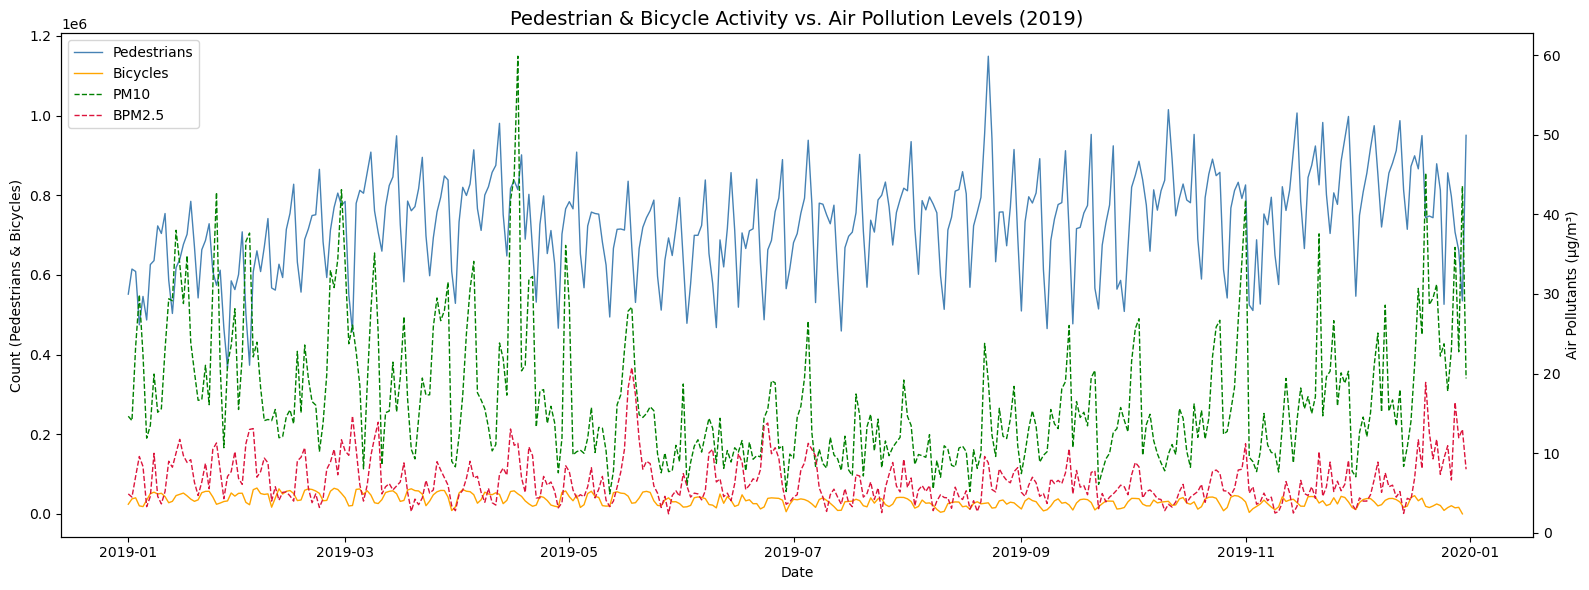

In [26]:
combined_df_before_covid = combined_df_before_covid.sort_index()

fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(combined_df_before_covid.index, combined_df_before_covid['pedestrian'], label='Pedestrians', color='steelblue', linewidth=1)
ax1.plot(combined_df_before_covid.index, combined_df_before_covid['bicycle_count'], label='Bicycles', color='orange', linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Count (Pedestrians & Bicycles)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.plot(combined_df_before_covid.index, combined_df_before_covid['pm10'], label='PM10', color='green', linestyle='--', linewidth=1)
ax2.plot(combined_df_before_covid.index, combined_df_before_covid['bpm2.5'], label='BPM2.5', color='crimson', linestyle='--', linewidth=1)
ax2.set_ylabel('Air Pollutants (µg/m³)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Pedestrian & Bicycle Activity vs. Air Pollution Levels (2019)', fontsize=14)
plt.tight_layout()
plt.show()

By examing the info and line chart of dataset before COVID period, there exists one missing data for bicycle_count. This missing data will be imputed using the median value of all the bicycle counts in 2019 period.

In [27]:
median_val = int(combined_df_before_covid["bicycle_count"].median())

combined_df_before_covid["bicycle_count"].fillna(median_val, inplace=True)

combined_df_before_covid["bicycle_count"] = combined_df_before_covid["bicycle_count"].astype(int)

C:\Users\PCs\AppData\Local\Temp\ipykernel_20808\4169386091.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df_before_covid["bicycle_count"].fillna(median_val, inplace=True)


In [28]:
print(combined_df_before_covid.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pedestrian     365 non-null    Int64  
 1   bicycle_count  365 non-null    int64  
 2   bpm2.5         365 non-null    float64
 3   pm10           365 non-null    float64
dtypes: Int64(1), float64(2), int64(1)
memory usage: 14.6 KB
None


In [29]:
combined_df_after_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 983 entries, 2023-01-01 to 2025-09-08
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pedestrian     732 non-null    Int64  
 1   bicycle_count  539 non-null    Int64  
 2   pm10           733 non-null    float64
 3   sbpm25         732 non-null    float64
dtypes: Int64(2), float64(2)
memory usage: 40.3 KB


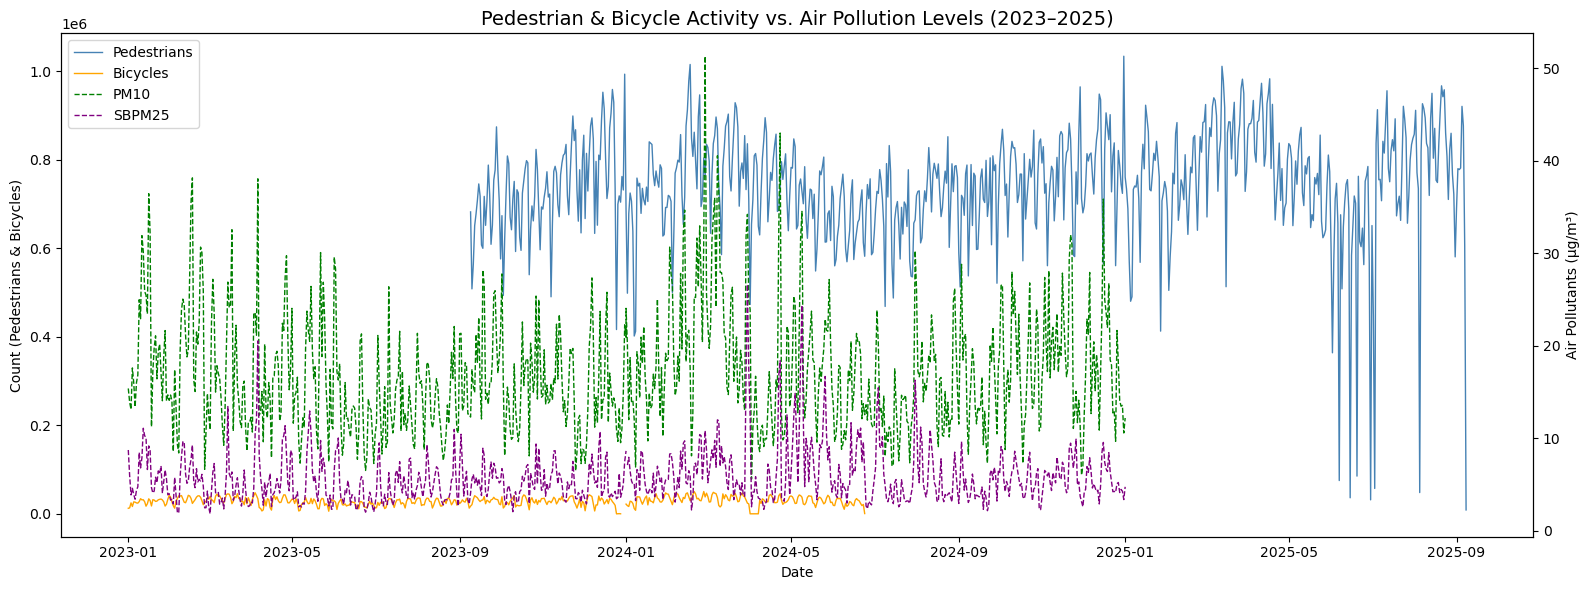

In [32]:
combined_df_after_covid = combined_df_after_covid.sort_index()

fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(combined_df_after_covid.index, combined_df_after_covid['pedestrian'], label='Pedestrians', color='steelblue', linewidth=1)
ax1.plot(combined_df_after_covid.index, combined_df_after_covid['bicycle_count'], label='Bicycles', color='orange', linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Count (Pedestrians & Bicycles)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.plot(combined_df_after_covid.index, combined_df_after_covid['pm10'], label='PM10', color='green', linestyle='--', linewidth=1)
ax2.plot(combined_df_after_covid.index, combined_df_after_covid['sbpm25'], label='SBPM25', color='purple', linestyle='--', linewidth=1)
ax2.set_ylabel('Air Pollutants (µg/m³)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Pedestrian & Bicycle Activity vs. Air Pollution Levels (2023–2025)', fontsize=14)
plt.tight_layout()
plt.show()

By examing the info and line chart of the dataset after COVID period, there exists multiple missing data points, and the missing data lie in different timeframes. It is unreasonable to impute the missing data with any special value. Therefore, we will take a subset of the dataset after COVID where all the data of pedestrian, bicycle, and air quality exist. The subset, which we will use, will cover the period from September 2023 to July 2024.

In [33]:
subset_after_covid = combined_df_after_covid.dropna(
    subset=["pedestrian", "bicycle_count", "pm10", "sbpm25"]
)

print("Subset date range:", subset_after_covid.index.min(), "to", subset_after_covid.index.max())
print("Shape:", subset_after_covid.shape)

Subset date range: 2023-09-09 00:00:00 to 2024-06-24 00:00:00
Shape: (287, 4)


In [34]:
subset_after_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 287 entries, 2023-09-09 to 2024-06-24
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pedestrian     287 non-null    Int64  
 1   bicycle_count  287 non-null    Int64  
 2   pm10           287 non-null    float64
 3   sbpm25         287 non-null    float64
dtypes: Int64(2), float64(2)
memory usage: 11.8 KB


### Data Exploration and Visualisation

This section explores the relationship between pedestrian activity, bicycle usage, and air quality in Melbourne from 2019 to 2024. After merging and cleaning the datasets, a suite of visualisations was generated to highlight differences between before COVID (2019) and after COVID (Sep 2023 to Jun 2024) periods. The analysis focused on seasonal variation, long-term dynamics, and correlations between movement and pollutants (PM10 and PM2.5).

- Comparative bar charts were used to show average daily activity and pollutant levels across the two periods, providing a clear baseline comparison.

- Boxplots captured the full distributions of activity and pollutant measures, revealing skewness, spread, and outliers across years.

- Rolling Z-score time series illustrated daily fluctuations and anomalies in  both activity and air quality, making seasonal cycles and unusual deviations more apparent.

- Scatterplots with regression lines quantified the strength of associations between pedestrian/bicycle activity and pollutant levels, supported by slopes and R² values.

- Monthly average line charts highlighted seasonal patterns, such as winter dips in cycling or pollutant peaks in cooler months.

- Correlation heatmaps summarised how pedestrian and bicycle counts related to PM10 and PM2.5 in each period, allowing for quick comparison of pre vs post COVID relationships.

These visualisations provide a layered perspective: bar charts and line plots highlight averages and trends; boxplots and rolling Z-scores show variability and anomalies; scatterplots and heatmaps test relationships and dependencies. This combination offers a more complete view of how mobility and environmental conditions interact over time.

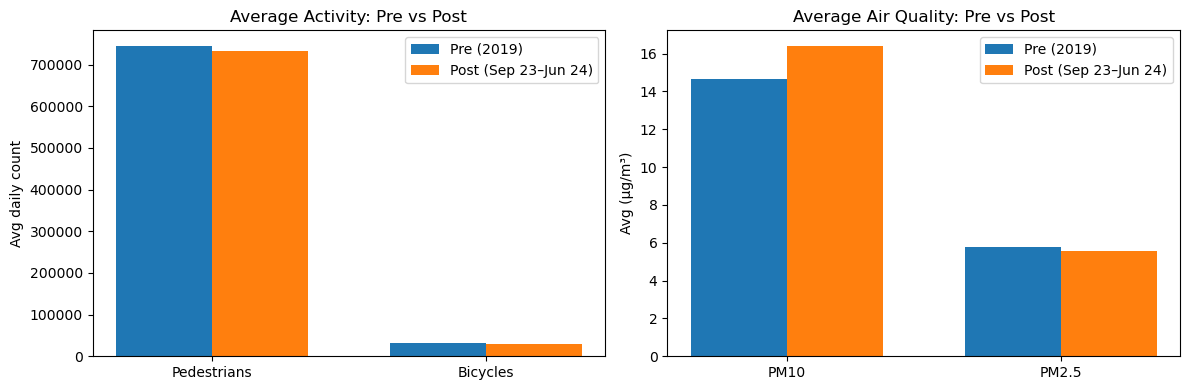

In [35]:
before = combined_df_before_covid.rename(columns={"bpm2.5": "pm25"})[["pedestrian", "bicycle_count", "pm10", "pm25"]]
after  = subset_after_covid.rename(columns={"sbpm25": "pm25"})[["pedestrian", "bicycle_count", "pm10", "pm25"]]

# Bar chart of middle point values
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
pre_median  = before[["pedestrian","bicycle_count"]].median()
post_median = after[["pedestrian","bicycle_count"]].median()
x = np.arange(2)
w = 0.35
ax[0].bar(x - w/2, pre_median.values, width=w, label="Pre (2019)")
ax[0].bar(x + w/2, post_median.values, width=w, label="Post (Sep 23–Jun 24)")
ax[0].set_xticks(x)
ax[0].set_xticklabels(["Pedestrians","Bicycles"])
ax[0].set_ylabel("Avg daily count")
ax[0].set_title("Average Activity: Pre vs Post")
ax[0].legend()

pre_aq_median  = before[["pm10","pm25"]].median()
post_aq_median = after[["pm10","pm25"]].median()
x = np.arange(2)
ax[1].bar(x - w/2, pre_aq_median.values, width=w, label="Pre (2019)")
ax[1].bar(x + w/2, post_aq_median.values, width=w, label="Post (Sep 23–Jun 24)")
ax[1].set_xticks(x)
ax[1].set_xticklabels(["PM10","PM2.5"])
ax[1].set_ylabel("Avg (µg/m³)")
ax[1].set_title("Average Air Quality: Pre vs Post")
ax[1].legend()
plt.tight_layout()
plt.show()

According to the bar chart of average activity, the average daily pedestrian count is very similar before and after COVID. There is a very slight decrease in the post-COVID period, but it is marginal. Hence, pedestrian activity has remained stable overall. Morever, the average daily cyclist count is slightly lower after COVID compared to before COVID. The reduction is noticeable but not dramatic. Therefore, cycling activity has declined slightly after COVID. Based on the bar chart of average air quality, while PM10 increased, PM2.5 slightly decreased after COVID.

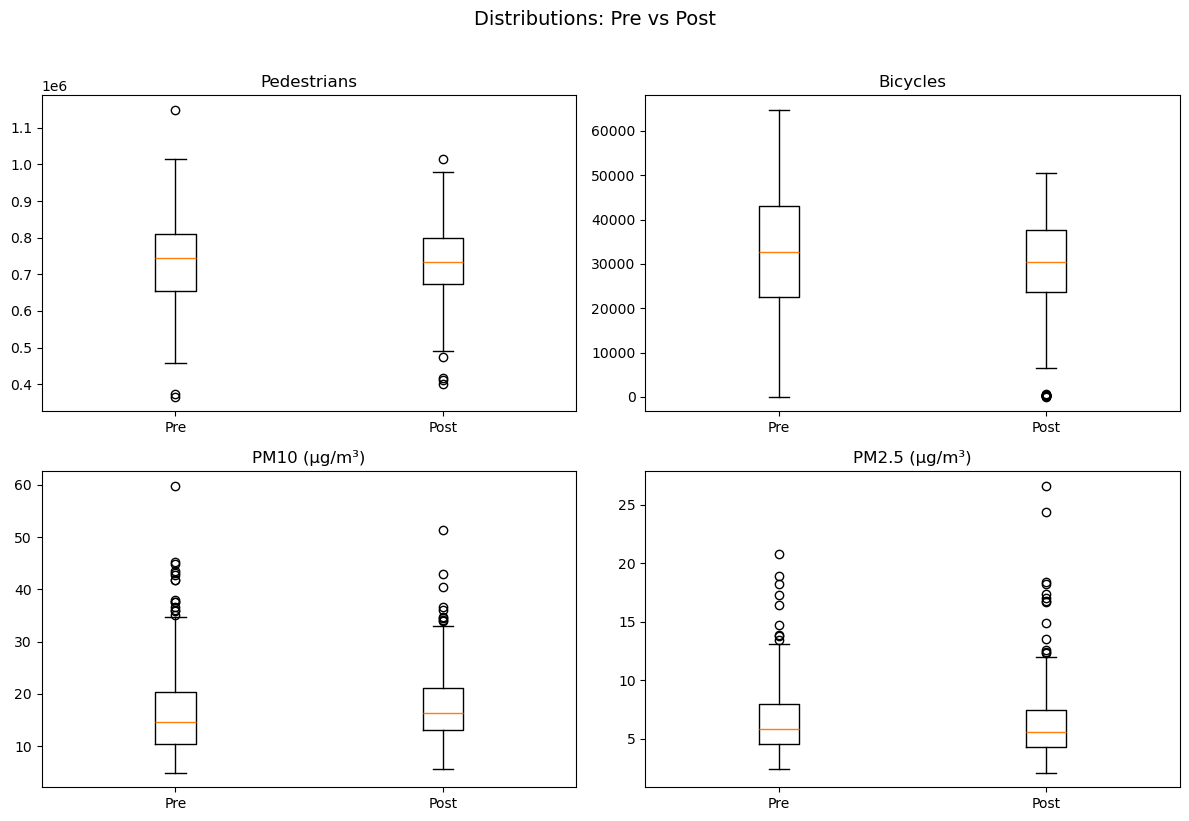

In [36]:
# Boxplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0,0].boxplot([before["pedestrian"], after["pedestrian"]], tick_labels=["Pre","Post"])
ax[0,0].set_title("Pedestrians")

ax[0,1].boxplot([before["bicycle_count"], after["bicycle_count"]], tick_labels=["Pre","Post"])
ax[0,1].set_title("Bicycles")

ax[1,0].boxplot([before["pm10"], after["pm10"]], tick_labels=["Pre","Post"])
ax[1,0].set_title("PM10 (µg/m³)")

ax[1,1].boxplot([before["pm25"], after["pm25"]], tick_labels=["Pre","Post"])
ax[1,1].set_title("PM2.5 (µg/m³)")

plt.suptitle("Distributions: Pre vs Post", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

According to the boxplot, with the median nearly identical before and after COVID, and IQR ranges overlap substantially, pedestrian activity has not changed much between before and after COVID, which is similar to our conclusion in the bar chart. In the bicycles box, the median is slightly lower in the after COVID period and the spread in before COVID period shows more variability, while after COVID is tighter but shifted slightly downward. This indicates cycling activity decreased somewhat after COVID, with fewer very high cycling days. In PM10 box, the median is slightly higher for after COVID period, and both periods show wide variability, but after COVID has more moderate values clustered in the middle, meaning PM10 levels increased a little on average, but variability remains high. Lastly, in the PM2.5 box, medians are almost the same for before and after COVID period with similar distribution. Hence, PM2.5 levels are stable overall, with no major shift.

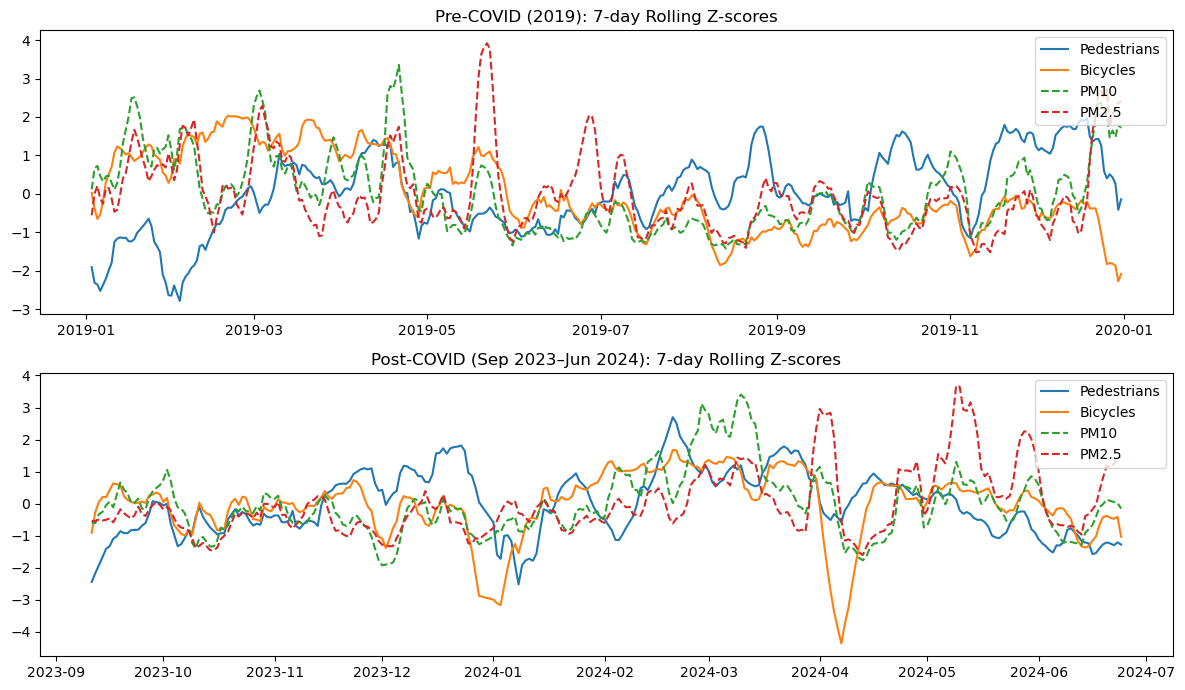

In [37]:
def zscore(s):
    s = s.astype(float)
    return (s - s.mean()) / (s.std(ddof=1) if s.std(ddof=1) else 1.0)

# Time series with 7-day rolling means
fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=False)

before_rm = before.rolling(7, min_periods=3).mean()
after_rm  = after.rolling(7, min_periods=3).mean()

ax[0].plot(before_rm.index, zscore(before_rm["pedestrian"]), label="Pedestrians")
ax[0].plot(before_rm.index, zscore(before_rm["bicycle_count"]), label="Bicycles")
ax[0].plot(before_rm.index, zscore(before_rm["pm10"]), label="PM10", linestyle="--")
ax[0].plot(before_rm.index, zscore(before_rm["pm25"]), label="PM2.5", linestyle="--")
ax[0].set_title("Pre-COVID (2019): 7-day Rolling Z-scores")
ax[0].legend(loc="upper right")

ax[1].plot(after_rm.index, zscore(after_rm["pedestrian"]), label="Pedestrians")
ax[1].plot(after_rm.index, zscore(after_rm["bicycle_count"]), label="Bicycles")
ax[1].plot(after_rm.index, zscore(after_rm["pm10"]), label="PM10", linestyle="--")
ax[1].plot(after_rm.index, zscore(after_rm["pm25"]), label="PM2.5", linestyle="--")
ax[1].set_title("Post-COVID (Sep 2023–Jun 2024): 7-day Rolling Z-scores")
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

According to the rolling Z-score time series, pedestrian movement remains broadly seasonal but appears a bit more volatile in the after COVID period. Cycling activity has weakened slightly compared to 2019, aligning with what the bar and boxplots showed. PM10 remains seasonally influenced, but extreme pollution events seem less frequent after COVID. PM2.5 continues to fluctuate sharply, showing little systematic improvement after COVID.

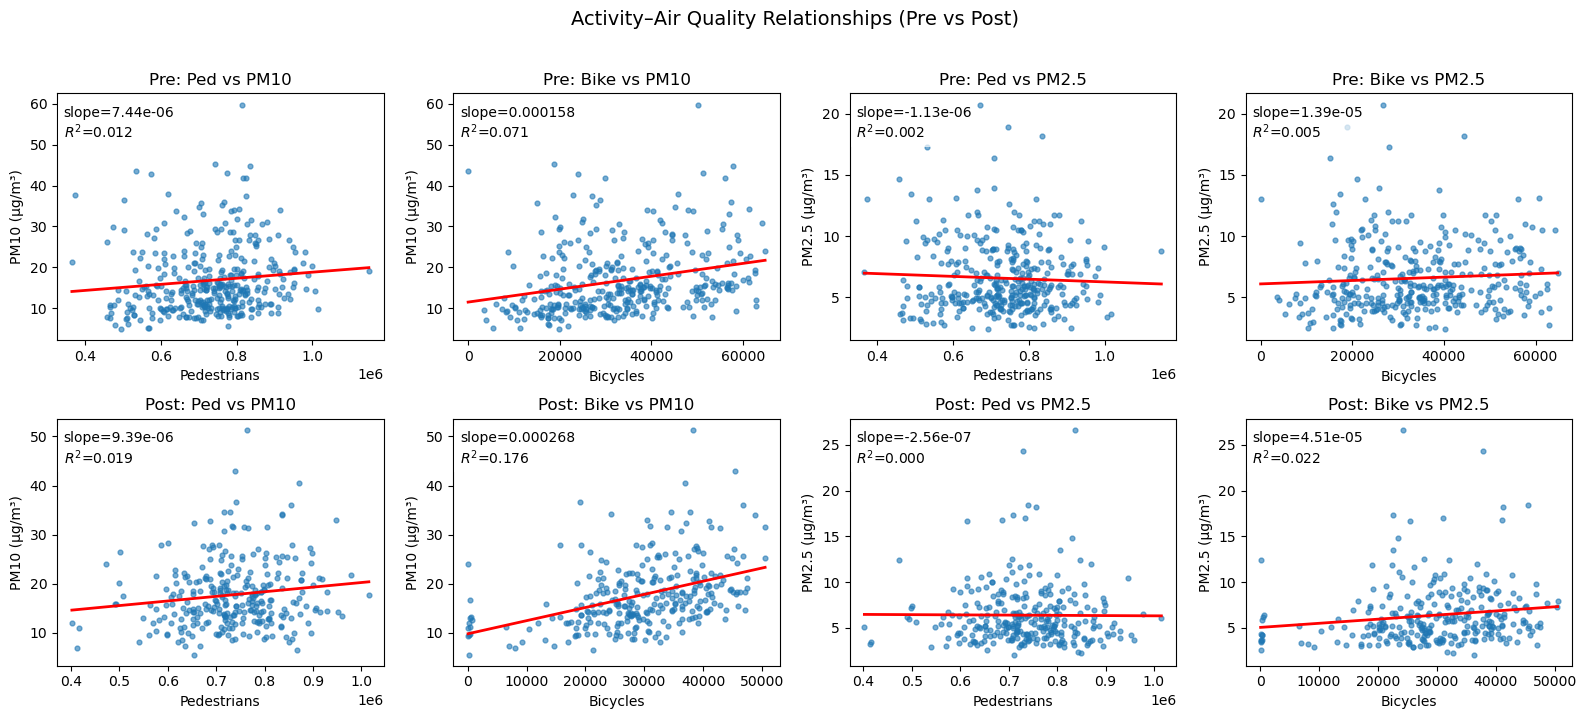

In [39]:
# The combination of scatter and regression
def scatter_with_fit(ax, x, y, title, xlabel, ylabel):
    x = pd.Series(x, dtype=float)
    y = pd.Series(y, dtype=float)
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]
    ax.scatter(x, y, s=12, alpha=0.6)
    if len(x) > 2:
        m, b = np.polyfit(x, y, 1)
        xx = np.linspace(x.min(), x.max(), 100)
        yy = m*xx + b
        ax.plot(xx, yy, linewidth=2, color="red")
        # R^2
        yhat = m*x + b
        r2 = 1 - np.sum((y - yhat)**2) / np.sum((y - y.mean())**2)
        ax.text(0.02, 0.95, f"slope={m:.3g}\n$R^2$={r2:.3f}", transform=ax.transAxes,
                va="top", ha="left", bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

fig, axes = plt.subplots(2, 4, figsize=(16, 7))

scatter_with_fit(axes[0,0], before["pedestrian"],    before["pm10"],   "Pre: Ped vs PM10",   "Pedestrians",   "PM10 (µg/m³)")
scatter_with_fit(axes[0,1], before["bicycle_count"], before["pm10"],   "Pre: Bike vs PM10",  "Bicycles",      "PM10 (µg/m³)")
scatter_with_fit(axes[0,2], before["pedestrian"],    before["pm25"],   "Pre: Ped vs PM2.5",  "Pedestrians",   "PM2.5 (µg/m³)")
scatter_with_fit(axes[0,3], before["bicycle_count"], before["pm25"],   "Pre: Bike vs PM2.5", "Bicycles",      "PM2.5 (µg/m³)")

scatter_with_fit(axes[1,0], after["pedestrian"],     after["pm10"],    "Post: Ped vs PM10",   "Pedestrians",  "PM10 (µg/m³)")
scatter_with_fit(axes[1,1], after["bicycle_count"],  after["pm10"],    "Post: Bike vs PM10",  "Bicycles",     "PM10 (µg/m³)")
scatter_with_fit(axes[1,2], after["pedestrian"],     after["pm25"],    "Post: Ped vs PM2.5",  "Pedestrians",  "PM2.5 (µg/m³)")
scatter_with_fit(axes[1,3], after["bicycle_count"],  after["pm25"],    "Post: Bike vs PM2.5", "Bicycles",     "PM2.5 (µg/m³)")

plt.suptitle("Activity–Air Quality Relationships (Pre vs Post)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

The chart shows a scatterplot with regression lines between human activity and air quality indicators. Looking at the relationship between pedestrians and both PM10 and PM2.5, more pedestrians might correlate with slightly higher PM10 but the effect is negligible, and it appears that pedestrian numbers do not affect PM2.5 levels. However, the results are quite different for bicycles. It shows that bicycle activity has a more noticeable correlation with PM10 after COVID, though this might be due to shared external drivers rather than causation. At the same time, more bicycles coincide with slightly higher PM2.5, but the effect is still minimal.

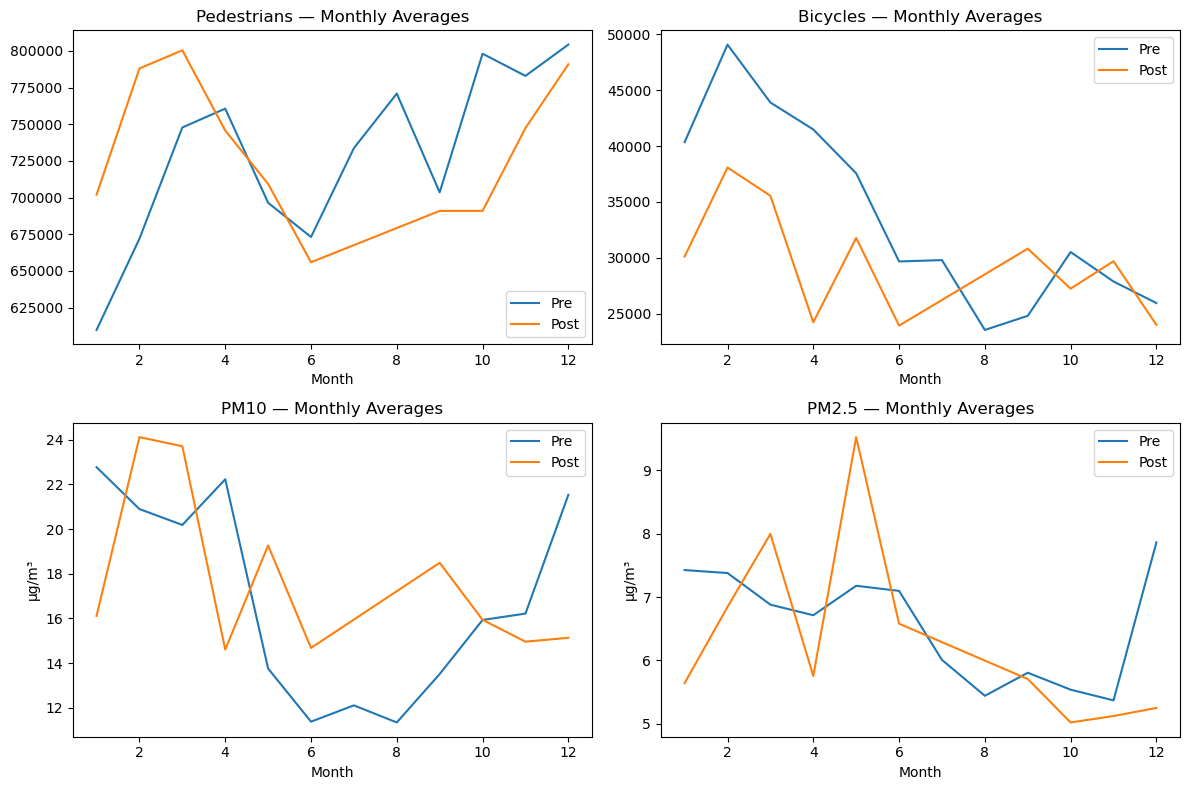

In [40]:
# Monthly average linee charts
before_monthly = before.groupby(before.index.month).mean()
after_monthly  = after.groupby(after.index.month).mean()

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0,0].plot(before_monthly.index, before_monthly["pedestrian"], label="Pre")
ax[0,0].plot(after_monthly.index,  after_monthly["pedestrian"],  label="Post")
ax[0,0].set_title("Pedestrians — Monthly Averages"); ax[0,0].set_xlabel("Month"); ax[0,0].legend()

ax[0,1].plot(before_monthly.index, before_monthly["bicycle_count"], label="Pre")
ax[0,1].plot(after_monthly.index,  after_monthly["bicycle_count"],  label="Post")
ax[0,1].set_title("Bicycles — Monthly Averages"); ax[0,1].set_xlabel("Month"); ax[0,1].legend()

ax[1,0].plot(before_monthly.index, before_monthly["pm10"], label="Pre")
ax[1,0].plot(after_monthly.index,  after_monthly["pm10"],  label="Post")
ax[1,0].set_title("PM10 — Monthly Averages"); ax[1,0].set_xlabel("Month"); ax[1,0].set_ylabel("µg/m³"); ax[1,0].legend()

ax[1,1].plot(before_monthly.index, before_monthly["pm25"], label="Pre")
ax[1,1].plot(after_monthly.index,  after_monthly["pm25"],  label="Post")
ax[1,1].set_title("PM2.5 — Monthly Averages"); ax[1,1].set_xlabel("Month"); ax[1,1].set_ylabel("µg/m³"); ax[1,1].legend()

plt.tight_layout()
plt.show()

This chart shows monthly averages for pedestrians, bicycles, and air pollutants, comparing before COVID (2019) and after COVID (Sep 2023–Jun 2024). It helps reveal seasonal patterns and differences between the two periods. The pedestrian trends are still seasonal, with some stronger early year activity after COVID. While, cycling activity has declined after COVID, even after adjusting for seasonal effects. For air quality indicators, PM10 pollution levels have increased somewhat after COVID, especially in early months. For PM2.5, the fluctuations have become more pronounced after COVID, with short-term peaks followed by lower values later.

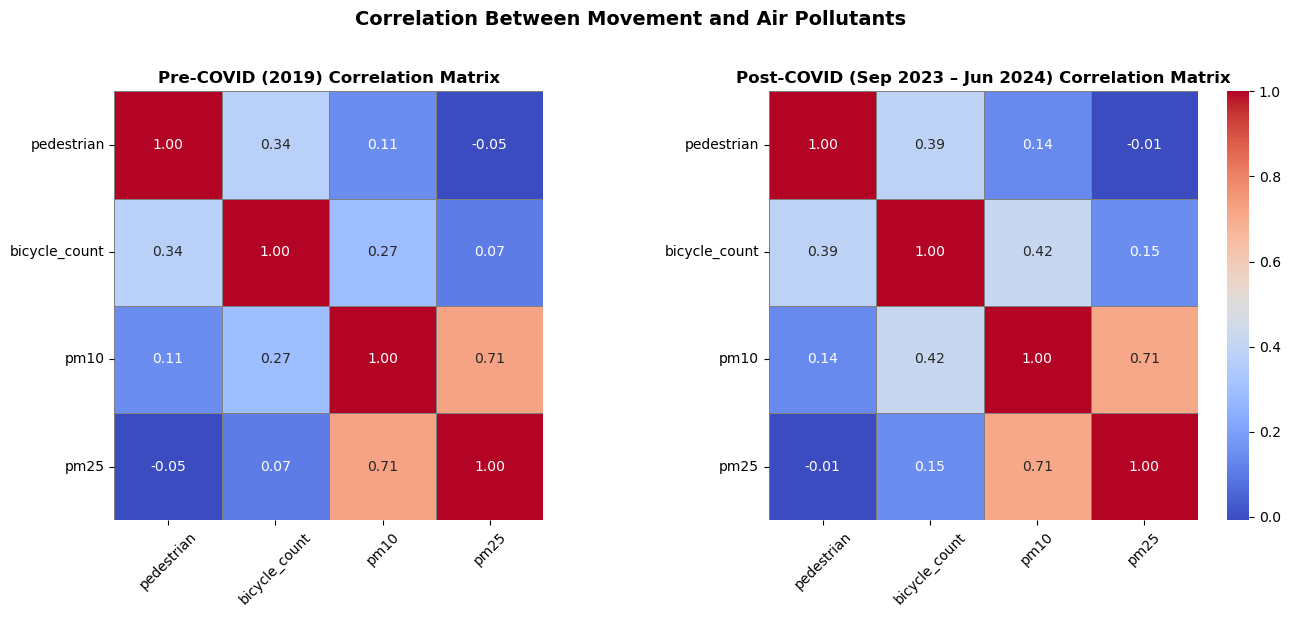

In [41]:
corr_before = before.corr(method="pearson")
corr_after = after.corr(method="pearson")

# Heatmap correlation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(
    corr_before, annot=True, cmap="coolwarm", fmt=".2f",
    linewidths=0.5, linecolor="gray", square=True, cbar=False, ax=axes[0]
)
axes[0].set_title("Pre-COVID (2019) Correlation Matrix", fontsize=12, weight="bold")
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(
    corr_after, annot=True, cmap="coolwarm", fmt=".2f",
    linewidths=0.5, linecolor="gray", square=True, cbar=True, ax=axes[1]
)
axes[1].set_title("Post-COVID (Sep 2023 – Jun 2024) Correlation Matrix", fontsize=12, weight="bold")
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.suptitle("Correlation Between Movement and Air Pollutants", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

Based on the heatmap correlation, it appears that pedestrian activity remains essentially unrelated to air pollution in both periods. However, cycling shows a clearer positive association with pollutants after COVID, though still not very strong. PM10 and PM2.5 are consistently linked, reflecting shared sources.

### Data Analysis

This section runs two separate models to test whether pedestrian and bicycle activity helps explain variation in air quality (PM10 and PM2.5) before and after COVID statistically. The first model is the Ordinary Least Squares (OLS) model. By including both pedestrian and bicycle counts, the result will show whether one has more explanatory power while adjusting for the other. The OLD model applied separately regressions for before COVID (2019) and  after COVID (Sep 2023–Jun 2024) periods to test whether those relationships changed over time.

#### Ordinary Least Squares regression model

In [46]:
before = combined_df_before_covid.rename(columns={"bpm2.5": "pm25"}).copy()
after  = subset_after_covid.rename(columns={"sbpm25": "pm25"}).copy()

cols = ["pedestrian", "bicycle_count", "pm10", "pm25"]
before = before[cols].copy()
after  = after[cols].copy()

def to_numeric_df(df):
    out = df.copy()
    for c in out.columns:
        out[c] = (
            out[c].astype(str)
                   .str.replace(",", "", regex=False)
                   .str.replace(" ", "", regex=False)
        )
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

before = to_numeric_df(before).dropna(how="any")
after  = to_numeric_df(after).dropna(how="any")

def add_scaled(X):
    out = X.copy()
    out["pedestrian_scaled"] = out["pedestrian"] / 1_000.0
    out["bicycle_scaled"]    = out["bicycle_count"] / 100.0
    return out

before = add_scaled(before)
after  = add_scaled(after)

# Ordinary Least Squares (OLS)
def run_ols(df, y_col, use_bike_only=False):
    if use_bike_only:
        X = df[["bicycle_scaled"]]
    else:
        X = df[["pedestrian_scaled", "bicycle_scaled"]]
    X = sm.add_constant(X, has_constant="add")
    y = df[y_col].astype(float)
    model = sm.OLS(y, X, missing="drop").fit(cov_type="HC3")
    return model

models = {
    "Pre: PM10":  run_ols(before, "pm10", use_bike_only=False),
    "Pre: PM2.5": run_ols(before, "pm25", use_bike_only=False),
    "Post: PM10": run_ols(after,  "pm10", use_bike_only=False),
    "Post: PM2.5":run_ols(after,  "pm25", use_bike_only=False),
}

for name, m in models.items():
    print(f"\n{name}")
    print(m.summary())


Pre: PM10
                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     11.11
Date:                Wed, 10 Sep 2025   Prob (F-statistic):           2.08e-05
Time:                        00:52:58   Log-Likelihood:                -1280.7
No. Observations:                 365   AIC:                             2567.
Df Residuals:                     362   BIC:                             2579.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.579

According to the result of the OLS model for before COVID period, bicycle activity has a small but significant positive effect on PM10 (p < 0.001), while pedestrian activity is not significant (p = 0.685). Only around 7% of PM10 variation is explained, hence, the model is quite weak to explain the relationship between bicycle with pedetrian and PM10. For the PM2.5 model, neither pedestrians nor bicycles are significant predictors (p > 0.05). Similar to the model of PM10, the PM2.5 model shows very low explanatory power with only 1.1% of variation. Overall, before COVID, bicycle counts had some (weak) association with PM10, but overall, activity levels had little influence on pollutants. Looking at the OLS model after COVID period, bicycle activity has a much stronger and significant positive effect on PM10, while pedestrian activity remains insignificant (p = 0.617). The model has shown a stronger power in variation explanation with 18%. Similar to the PM10 model, pedestrian activity remains insignificant (p = 0.192), while bicycle activity is weakly significant. The model for PM2.5 demonstrates only around 3% of variation explained. To conclude, after COVID, bicycle activity shows a stronger statistical relationship with both PM10 and PM2.5 (especially PM10), and pedestrian activity continues to show no meaningful impact.

The second model is pooled interaction model. Instead of running separate models, pooling allows to estimate everything together. The model is use to explicitly test differences between periods. By adding a period dummy (0 = pre, 1 = post) and interaction terms (ped_period, bike_period), the model will check whether the effect of pedestrians or bicycles on air quality changed after COVID.

#### Pooled interaction model

In [48]:
# Pooled interaction model
b = before.copy(); b["period"] = 0  # pre
a = after.copy();  a["period"] = 1  # post
combined = pd.concat([b, a], axis=0, ignore_index=True)
combined = to_numeric_df(combined).dropna(how="any")

def interaction_model(df, y_col, use_bike_only=False):
    if use_bike_only:
        X = df[["bicycle_scaled", "period"]].astype(float)
        X["bike_period"] = X["bicycle_scaled"] * X["period"]
    else:
        X = df[["pedestrian_scaled", "bicycle_scaled", "period"]].astype(float)
        X["ped_period"]  = X["pedestrian_scaled"] * X["period"]
        X["bike_period"] = X["bicycle_scaled"]    * X["period"]
    X = sm.add_constant(X, has_constant="add")
    y = df[y_col].astype(float)
    return sm.OLS(y, X, missing="drop").fit(cov_type="HC3")

print("\n\nPooled Interaction — PM10")
print(interaction_model(combined, "pm10", use_bike_only=False).summary())

print("\n\nPooled Interaction — PM2.5")
print(interaction_model(combined, "pm25", use_bike_only=False).summary())



Pooled Interaction — PM10
                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     17.35
Date:                Wed, 10 Sep 2025   Prob (F-statistic):           3.90e-16
Time:                        01:03:08   Log-Likelihood:                -2221.4
No. Observations:                 652   AIC:                             4455.
Df Residuals:                     646   BIC:                             4482.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const     

Looking at the model of PM10, the pedestrian variable shows a small coefficient and is not significant. There is no real effect on PM10, consistent with earlier models. Meanwhile, bicycle shows positive and significant with p < 0.001. More bicycles are associated with higher PM10. The period dummy shows an insignificant (p = 0.516). The baseline PM10 level is not dramatically different once controlling for activity. Considering the interaction terms, there is no change in pedestrian effect after COVID as the ped_period is not signficant enough (p = 0.614). However, bike_period is positive and significant, meaning the effect of bicycles on PM10 became stronger after COVID. Similar to the PM10 model, the pedestrian variable also has no effect on PM2.5. Bicycle has a small relationship with PM2.5 as a weak positive coefficient and borderline significance existed. The period dummy variable again is not significant (p = 0.659), indicating average PM2.5 levels did not shift much across periods once controlling for activity. Considering interaction terms, ped_period is not significant enough with p = 0.653, meaning no change in pedestrian effect. Meanwhile, it also shows no clear evidence that bicycle and PM2.5 relationship changed. In conclusion, cycling is linked to higher PM10 overall, and this effect increased after COVID. PM2.5 remains mostly unaffected by pedestrian or cycling activity, though bicycles show a small weak association that does not materially change after COVID.

Even though it is expected that increasing bicycle activity should improve air quality or reduce PM10 and PM2.5 in the air, both models show that the bicycle variable has a positive relationship with both PM10 and PM2.5. This does not mean bikes cause pollution directly, but it likely reflects confounding factors. High bicycle activity and high pollution could both occur on the same days. Dry conditions increase road dust resuspension (PM10), while also making cycling more appealing. Moreover, cycling often occurs alongside road traffic. More bikes may coincide with busier traffic periods, meaning higher background emissions from vehicles. Due to these possible confounding factors, further research is required to truly understand whether there is any relationship between both pedestrian and bicycle activity and air quality indicators. A recommendation for further research are comparing pollution levels on high-cycling streets vs lower-cycling streets, rather than just citywide averages. This could show whether pollution is driven by traffic exposure rather than cycling activity itself.